In [ ]:
#@title **MONTAR EL DRIVE** { display-mode: "form" }
import os
from google.colab import drive

path_ai = "Dataset_AI" #@param {type:"string"}
path = "/content/drive/MyDrive/" + path_ai
drive.mount('/content/drive')
os.chdir(path)
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Dataset_AI


# **Biometric Falcon Eye**
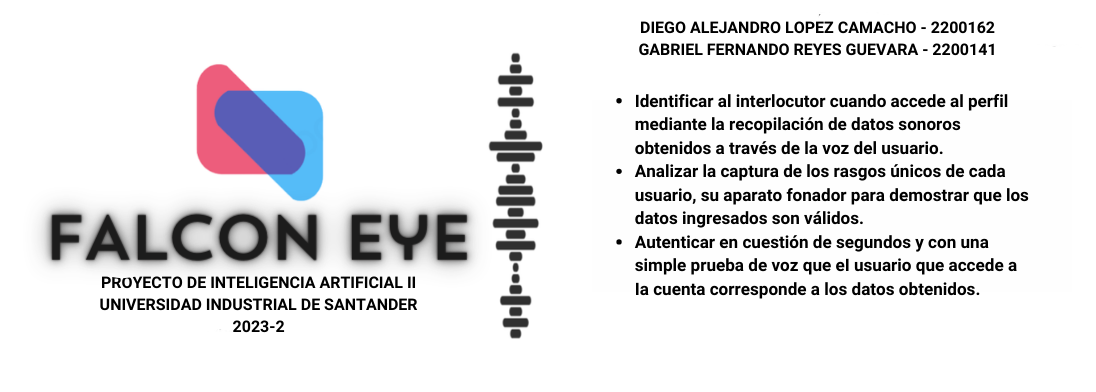

## **INTEGRANTES**


*   **Diego Alejandro Lopez Camacho - 2200162**
*   **Gabriel Fernando Reyes Guevara - 2200141**

### Descripcion del proyecto
Este proyecto se enfoca en el desarrollo de un avanzado sistema de reconocimiento de características en archivos de audio mediante el uso de Inteligencia Artificial, específicamente Redes Neuronales Profundas (DNN). Utilizando un dataset proporcionado por Mozilla, nuestro objetivo es entrenar una DNN que tenga la capacidad de identificar y clasificar diversas características en archivos de audio, tales como el género (hombre o mujer), la edad, y posiblemente otras características relevantes.

## Objetivo

- Recopilación y Preprocesamiento de Datos:

Recopilar un dataset exhaustivo de archivos de audio proporcionado por Mozilla.
Realizar tareas de preprocesamiento para garantizar la calidad y uniformidad de los datos, como la normalización del audio y la extracción de características relevantes.
- Entrenamiento de la Red Neuronal Profunda (DNN):

Diseñar y entrenar una DNN utilizando técnicas de aprendizaje profundo para reconocer patrones complejos en los archivos de audio.
Implementar algoritmos de optimización para mejorar la precisión y eficiencia del modelo.
- Clasificación de Características:

Desarrollar algoritmos de clasificación que permitan identificar el género (hombre/mujer) y estimar la edad en base a los patrones de audio identificados por la DNN.
Explorar posibles características adicionales, como el tono de voz, el estado emocional, etc., y clasificarlas adecuadamente.
- Evaluación y Validación del Modelo:

Evaluar el rendimiento del modelo utilizando métricas pertinentes como precisión, recall y F1-score.
Realizar pruebas de validación cruzada para asegurar la generalización del modelo a datos no vistos.
- Desarrollo de una Interfaz de Usuario (UI) (**OPCIONAL**):

Crear una interfaz fácil de usar que permita a los usuarios cargar archivos de audio y obtener las clasificaciones de características en tiempo real.
Implementar una funcionalidad para interpretar los resultados y mostrarlos de manera comprensible para los usuarios finales.



## CARGUE DE LIBRERIAS E IMPORTS

In [ ]:
#@title **Cargando Librerias** { display-mode: "form" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
sns.set_theme()
pd.__version__

'1.5.3'

In [ ]:
#@title Imports 1
colab_requirements = [
    "pip install librosa==0.9.2",
    "pip install noisereduce",
    "pip install soundfile",
    "pip install tensorflow"
    "pip install resampy"

]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

## CARGUE Y EXPLORACION DEL DATASET

Mozilla Common Voice es un proyecto de código abierto que busca hacer la tecnología de voz más inclusiva. Los colaboradores donan datos de voz a un conjunto de datos público, que cualquiera puede usar para entrenar tecnologías habilitadas para la voz. El objetivo es ayudar a enseñar a las máquinas cómo hablan las personas reales, en diferentes idiomas, acentos y edades

El conjunto de datos de Mozilla Common Voice tiene las siguientes características como dataset:

- Es el **más grande** de su tipo en el dominio público, con más de **29 mil horas** de voz en **87 idiomas**.
- Es de **código abierto** y tiene una licencia **CC-0**, lo que significa que cualquiera puede usarlo, modificarlo y compartirlo sin restricciones.
- Incluye **metadatos demográficos** como edad, sexo y acento de los colaboradores, que pueden ayudar a entrenar la precisión de las tecnologías de reconocimiento de voz.
- Está compuesto por **voces reales** de personas de todo el mundo, que reflejan la diversidad y la riqueza de las lenguas humanas.
- Se actualiza **periódicamente** con nuevas voces y lenguas, y ofrece segmentos delta que contienen los clips más recientes desde el último lanzamiento.


In [ ]:
import pandas as pd

d = pd.read_csv('common_voice.csv',sep=',')
data_rows, data_cols = d.shape
print(f'Hay {data_rows} filas y {data_cols} columnas')
d.dropna(inplace=False)
# Prettify the output of DataFrame columns
styled_columns = d.columns.to_frame(index=False, name='Column Names').style.set_properties(**{'text-align': 'left'})

# Display the prettified columns
styled_columns

Hay 6002 filas y 9 columnas


,Column Names
0,client_id
1,path
2,sentence
3,up_votes
4,down_votes
5,age
6,gender
7,accent
8,set


Aqui borramos los valores vacios, los audios que tienen votos en contra, y aquellos que no tienen votos a favor para podernos quedar con aquellos que ya fueron verificados por la gente del proyecto de COMMON VOICE,ademas, extraemos las columnas de interes, agregamos una extension .mp3 a los valores en 'PATH' ya que esto nos permitira manipularlos facilmente mas adelante; Por ultimo, verificamos que los valores nos conduzcan a un archivo fisico, de no ser asi eliminamos la fila.

In [ ]:
import pandas as pd
import os
import numpy as np
# Borrar todas las filas que tienen valores vacios
d.dropna(inplace=True)

# Verificar en la columna down_votes que su valor siempre sea 0, de lo contrario eliminar la fila
d = d[d['down_votes'] == 0]

# Verificar en la columna up_votes que su valor siempre sea diferente de 0, de lo contrario eliminar la fila
d = d[d['up_votes'] != 0]

# Extraer un dataset 'd1' con la filas path, age, gender
d1 = d[["path", "age", "gender", "set"]]

# Agregar al final de los valores de path .mp3
d1["path"] = d1["path"].apply(lambda x: f'{x}.mp3')

# Verificar que los valores de path conduzcan a un archivo dentro de la carpeta clips, de no ser asi borrar la fila
d1 = d1[d1['path'].apply(lambda x: os.path.isfile(f'clips/{x}'))]


<ipython-input-5-e41bc56040cf>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1["path"] = d1["path"].apply(lambda x: f'{x}.mp3')


de esta manera podemos obtener un dataset que se adapta de mejor manera a nuestras necesidades

In [ ]:
[d1[col].unique() for col in d1.columns[[2,1]]]

[array(['male', 'female'], dtype=object),
 array(['twenties', 'fourties', 'teens', 'fifties', 'thirties', 'sixties'],
       dtype=object)]

Pasamos los valores de las columnas age y gender a valores numericos que nos permitan manipularlos:


```
"teens": 1,
"twenties": 2,
"thirties": 3,
"fourties": 4,
"fifties": 5,
"sixties": 6
```
```
"male": 0,
"female": 1
```


In [ ]:
# Map age to appropriate numerical value
d1.loc[:, "age"] = d1["age"].map({
        "teens": 1,
        "twenties": 2,
        "thirties": 3,
        "fourties": 4,
        "fifties": 5,
        "sixties": 6})

# Map gender to corresponding numerical value
d1.loc[:, "gender"] = d1["gender"].map({"male": 0, "female": 1})

<ipython-input-7-6e7f7112bfb5>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  d1.loc[:, "age"] = d1["age"].map({
<ipython-input-7-6e7f7112bfb5>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  d1.loc[:, "gender"] = d1["gender"].map({"male": 0, "female": 1})


In [ ]:
print(d1.shape)
d1.head()

(2994, 4)


,path,age,gender,set
0,f2713195d4853b8e1a9c77c486d7ad8b82f8dcacb4795e...,2,0,train
1,1273f6099f14d2216c94330bf24f35d6c907a3f0a61f65...,2,0,train
2,8d73fdfa93d2f4d094e65ce5063f4cd2e19284e0d655fd...,2,0,train
3,5e61e289f4cd89c456b84979ea3721b286079729598b44...,2,0,train
4,277b45132872cc5b24341965ccdc2aa91ed7a3cfb5fd7f...,2,0,train


In [ ]:
print(d1['age'].value_counts())
print(d1['gender'].value_counts())
print(d1['set'].value_counts())

2    988
4    887
3    795
5    165
1    102
6     57
Name: age, dtype: int64
0    2604
1     390
Name: gender, dtype: int64
train    2111
test      883
Name: set, dtype: int64


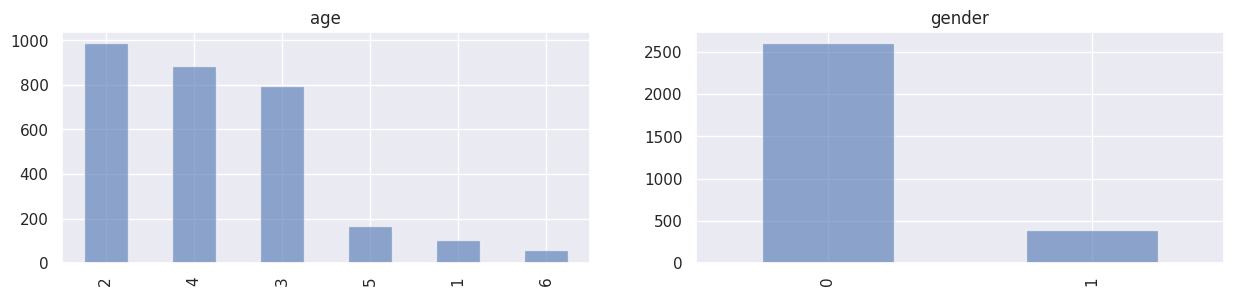

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for i, c in enumerate(["age", "gender"]):
    d1[c].value_counts().plot.bar(title=c, ax=axes[i], alpha=0.6)
plt.show();

## VISUALIZACION DE LOS ARCHIVOS

La manipulación de los archivos de audio incluirá procesos como la conversión de señales de onda de audio, la aplicación de la Transformada de Fourier para analizar la representación frecuencial de las señales, así como la Transformada de Fourier de Tiempo Corto (STFT) para explorar las variaciones espectrales a lo largo del tiempo.

Además, se emplearán técnicas avanzadas como el espectrograma de Mel para representar la distribución de energía de las señales en función del tiempo y la frecuencia, así como los coeficientes cepstrales de frecuencia Mel (MFCC) para capturar las características acústicas más relevantes. Estas herramientas ofrecerán una visión detallada de las características fundamentales de las grabaciones de voz, permitiendo un análisis preciso y exhaustivo de las variaciones tonales y lingüísticas presentes en el conjunto de datos. Este enfoque técnico garantizará una exploración profunda de las características acústicas, respaldando así los objetivos analíticos del proyecto.

### REPRESENTACION EN FORMA DE ONDA DEL AUDIO

00d15f6dae9953c2e3a3bc121b6644ba35e702915fedc58a0bb44b172e5a98342320de912709ebf47423e453a514d78f9e36c3580d4c263a4524b43d1fc78fb1.mp3


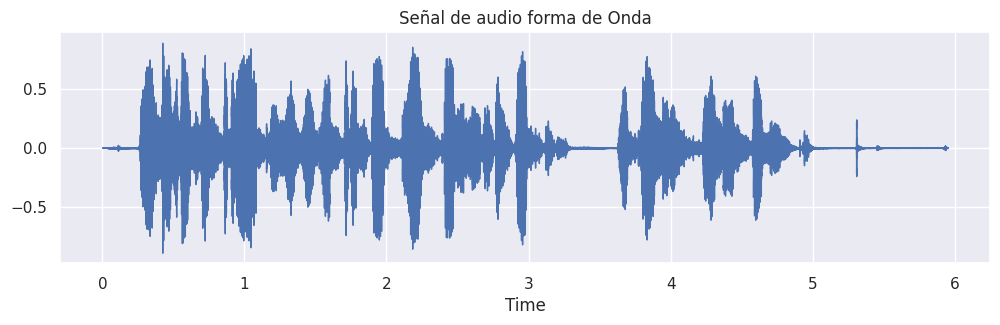

In [ ]:
import warnings
import librosa
import random
import os
from matplotlib import pyplot as plt
import librosa.display

warnings.filterwarnings("ignore")

# Selecciona aleatoriamente una fila del DataFrame
random_row = d1.sample()

# Obtiene el valor de la columna 'path' de la fila seleccionada
x = random_row['path'].values[0]

# Asegúrate de verificar que el archivo existe antes de intentar cargarlo
if os.path.exists(os.path.join('clips', x)):
    # Carga el archivo mp3 con una frecuencia de muestreo específica, aquí 16kHz
    y, sr = librosa.load(os.path.join('clips', x), sr=16_000)

    # Graficar la muestra almacenada en 'y'
    plt.figure(figsize=(12, 3))
    plt.title("Señal de audio forma de Onda")
    librosa.display.waveshow(y, sr=sr)
    print(x)
else:
    print(f"El archivo {os.path.join('clips', x)} no existe.")

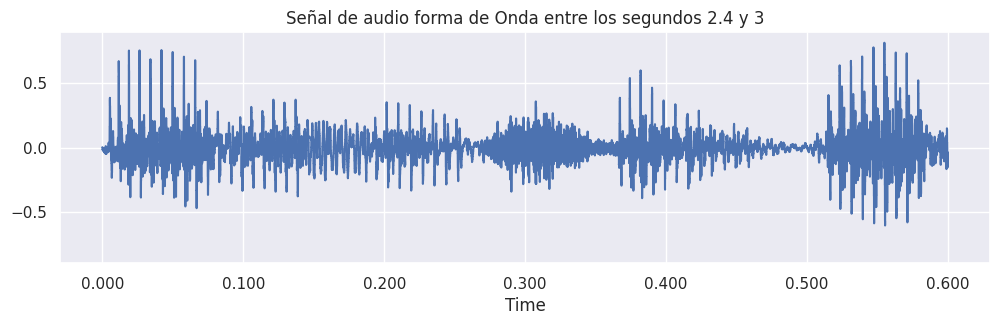

In [ ]:
# Define el periodo de tiempo de inicio y fin que quieres visualizar (en segundos)
start_time = 2.4
end_time = 3

# Convertir esos tiempos en indices
start_sample = int(start_time * sr)
end_sample = int(end_time * sr)

# Obtenga la sección del audio
y_section = y[start_sample:end_sample]

# Graficar la sección del audio almacenada en 'y_section'
from matplotlib import pyplot as plt
import librosa.display

plt.figure(figsize=(12, 3))
plt.title(f"Señal de audio forma de Onda entre los segundos {start_time} y {end_time}")
librosa.display.waveshow(y_section, sr=sr);


### TRANSFORMADA DE FURIER

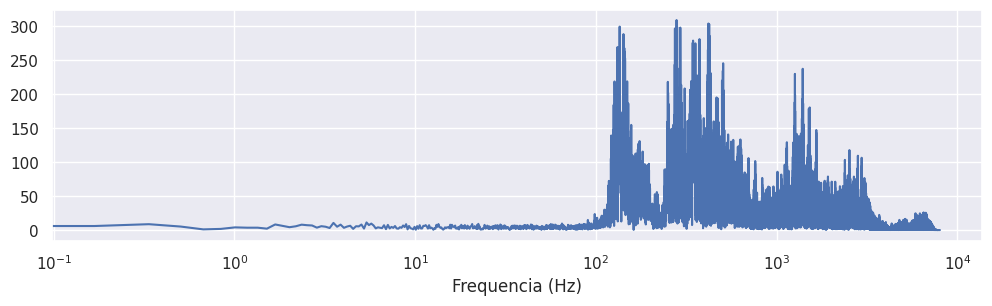

In [ ]:
import scipy
import numpy as np

# Aplica la transformación rápida de Fourier a la señal y toma los valores absolutos
y_freq = np.abs(scipy.fftpack.fft(y))

# Establece todas las frecuencias posibles (en función de la frecuencia de muestreo y la longitud de la señal)
f = np.linspace(0, sr, len(y_freq))

# Graficar la señal de audio como información de frecuencia.
plt.figure(figsize=(12, 3))
plt.semilogx(f[: len(f) // 2], y_freq[: len(f) // 2])
plt.xlabel("Frequencia (Hz)")
plt.show();

### TRANSFORMADA DE FOURIER DE TIEMPO CORTO (STFT)

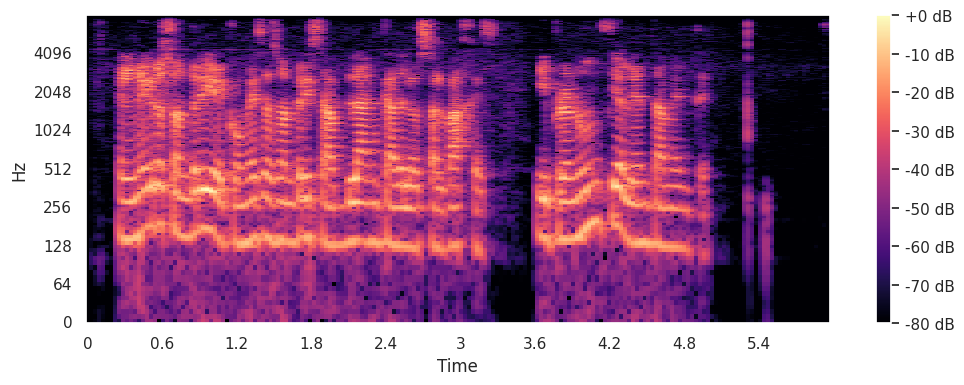

In [ ]:
import librosa.display

# Calcular la transformada de Fourier de corta duración
x_stft = np.abs(librosa.stft(y))

# Aplica la escala logarítmica de dB al espectrograma y fija el máximo en 0 dB
x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)

# Graficar espectrograma STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.show();


### ESPECTOGRAMA DE MEL

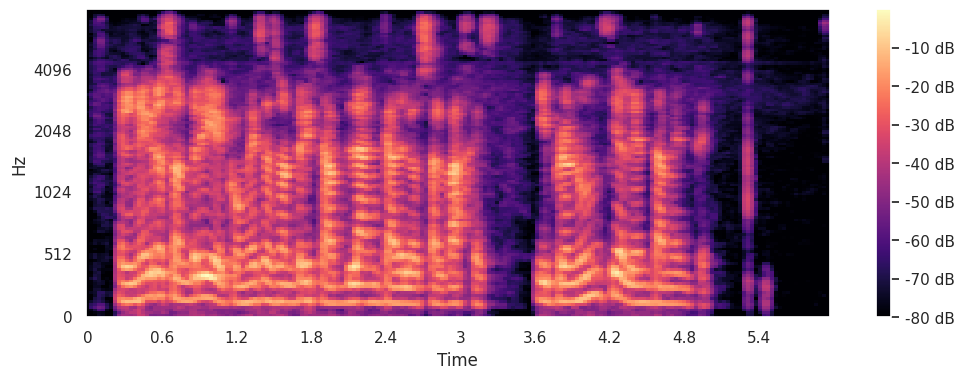

In [ ]:
# Calcular el espectrograma mel
x_mel = librosa.feature.melspectrogram(y=y, sr=sr)

# Aplica la escala logarítmica de dB al espectrograma y fija el máximo en 0 dB
x_mel = librosa.power_to_db(x_mel, ref=np.max)

# Graficar espectrograma mel
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_mel, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.show();


### COEFICIENTES CEPSTRALES DE FRECUENCIA MEL

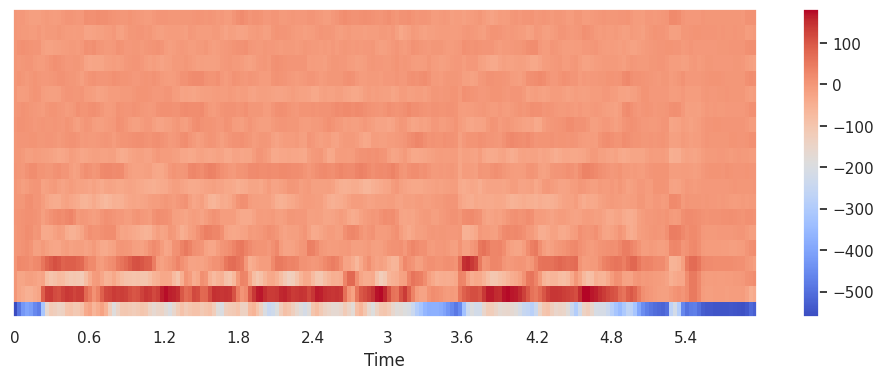

In [ ]:
# Extraer 'n_mfcc' números de componentes MFCCs (aquí 20)
x_mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

# Graficar MFCCs
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_mfccs, sr=sr, x_axis="time")
plt.colorbar()
plt.show();


## LIMPIEZA DE DATOS

Primeramente visualizaremos algunos archivos para ver su estructura

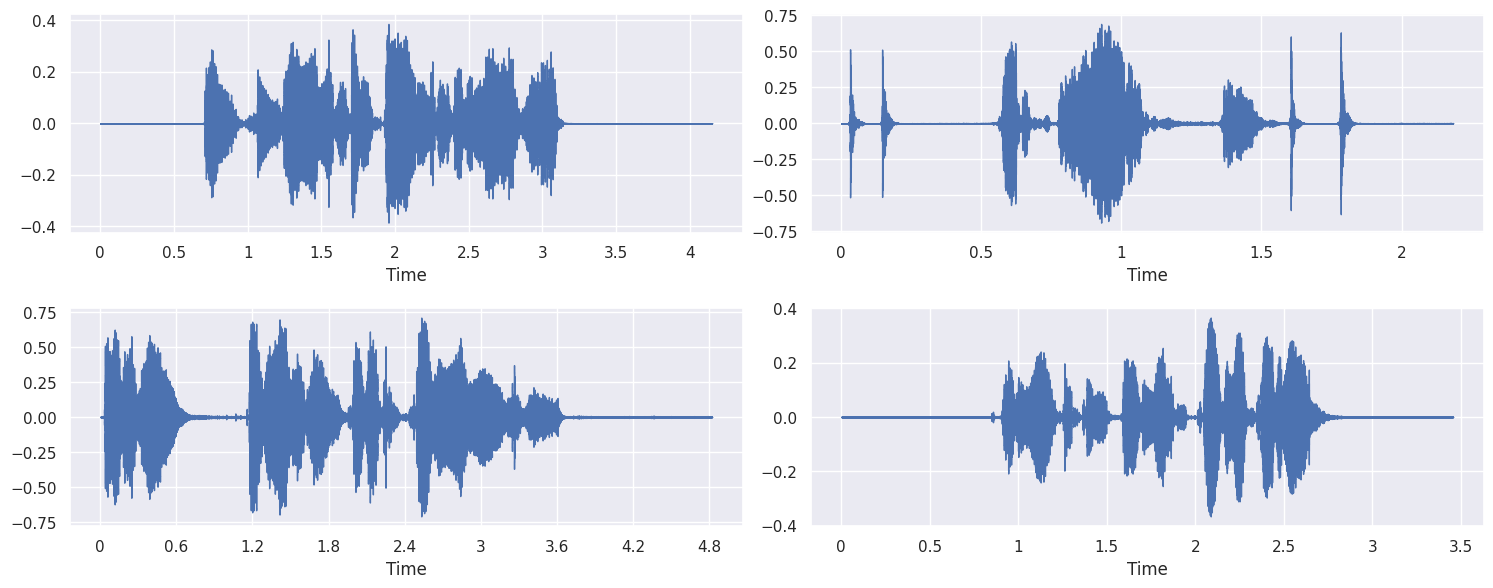

In [ ]:
import os
import random

# Listar todos los archivos de la carpeta 'clips'
all_files = os.listdir('clips/')

# Seleccionar 4 archivos al azar
selected_files = sorted(random.sample(all_files, 4))

# Ahora se pueden cargar y visualizar estos archivos
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    # Aquí tomamos los nombres de los archivos de la lista `selected_files`.
    fname = os.path.join('clips', selected_files[i])
    y, sr = librosa.load(fname, sr=16_000)
    librosa.display.waveshow(y=y, sr=sr, ax=ax)
plt.tight_layout()
plt.show()


Se evidencia en las graficas de onda que tienen un ruido de fondo variable que cubre múltiples frecuencias. Esto es también lo que vemos en las figuras de arriba. La muestra 2 es muy ruidosa en todo momento, mientras que la muestra 4 es ruidosa solo en unas pocas frecuencias.

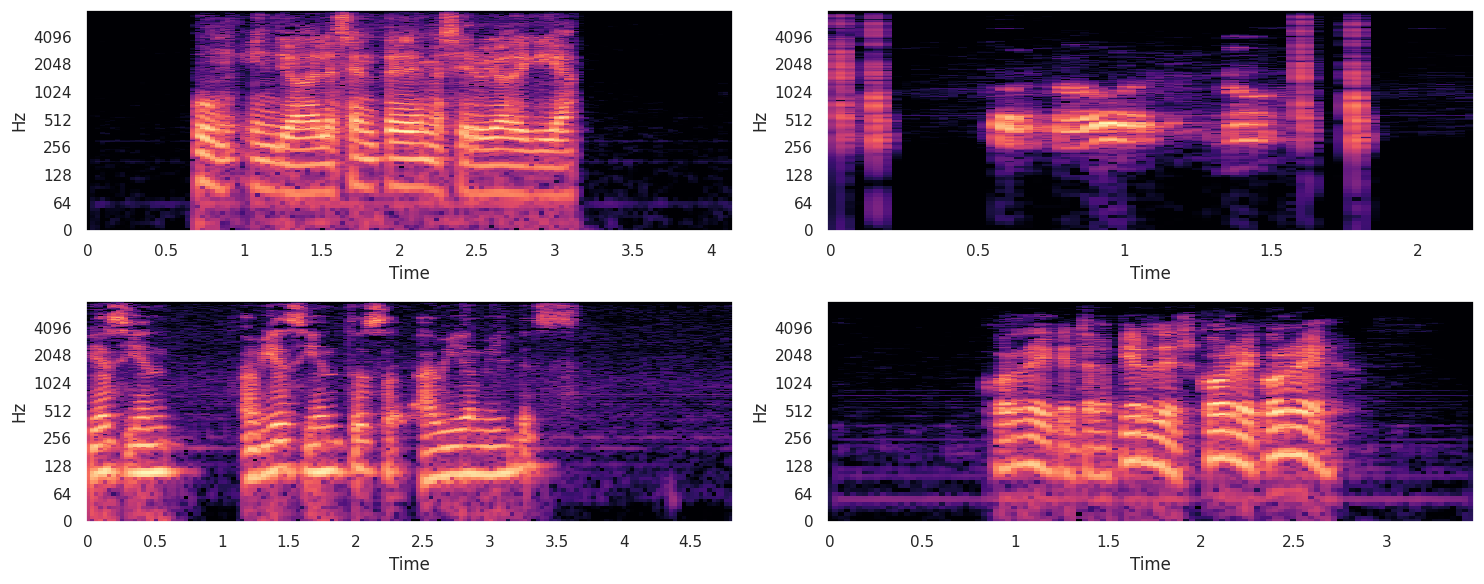

In [ ]:
# El código es el mismo que antes, utilizando la rutina stft-spectrogram
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    # Aquí tomamos los nombres de los archivos de la lista `selected_files`.
    fname = os.path.join('clips', selected_files[i])
    y, sr = librosa.load(fname, sr=16_000)

    # Aplicamos la transformada de Fourier de tiempo corto (STFT)
    x_stft = np.abs(librosa.stft(y))
    x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)

    # Visualizamos el espectrograma
    librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log", ax=ax)

plt.tight_layout()
plt.show()

Se realizo una preparacion de los datos porque se necesitaban adecuar los audios para su uso. Se procede entonces a eliminar el ruido de las muestras.

In [ ]:
import noisereduce as nr
from scipy.io import wavfile

for i, ax in enumerate(axs.flatten()):
    # Aquí tomamos los nombres de los archivos de la lista `selected_files`.
    fname = os.path.join('clips', selected_files[i])
    y, sr = librosa.load(fname, sr=16_000)

    # Eliminar el ruido de una muestra de audio
    reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False)

    # Guardar la salida en un archivo wav como mp3 no se puede guardar en directamente
    wavfile.write(fname.replace(".mp3", ".wav"), sr, reduced_noise)

In [ ]:
# Bucle a través de las cuatro muestras
for i, ax in enumerate(axs.flatten()):

    # Cargar archivo de audio
    fname = os.path.join('clips', selected_files[i])
    y, sr = librosa.load(fname, sr=16_000)

    # Señal de ajuste
    y_trim, _ = librosa.effects.trim(y, top_db=20)

    # Overwrite previous wav file
    wavfile.write(fname.replace(".mp3", ".wav"), sr, y_trim)

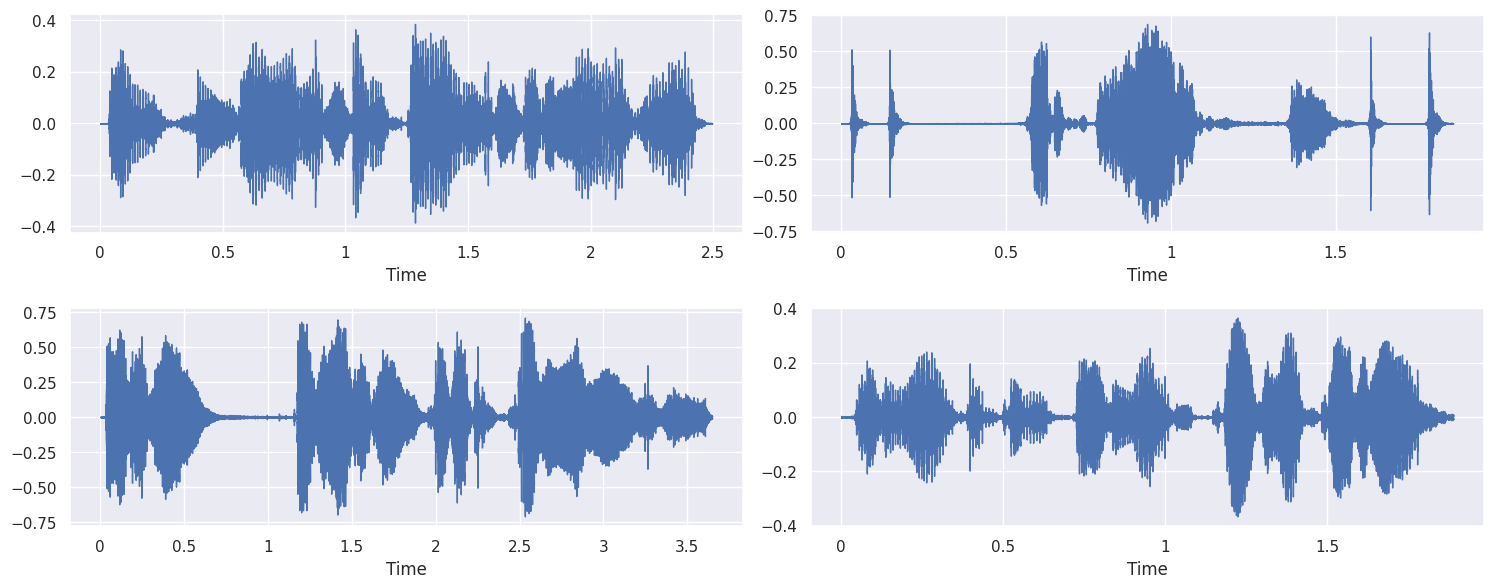

In [ ]:
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display

selected_files = [os.path.splitext(f)[0]+'.wav' for f in selected_files]

# Ahora se pueden cargar y visualizar estos archivos
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    # Evitar un error si hay menos de 4 archivos
    if i < len(selected_files):
        # Aquí tomamos los nombres de los archivos de la lista `selected_files`.
        fname = os.path.join('clips', selected_files[i])
        y, sr = librosa.load(fname, sr = 16000)
        librosa.display.waveshow(y = y, sr = sr, ax = ax)
plt.tight_layout()
plt.show()

Aca podemos ver como se redujeron silencios y se adecuaron mejor los audios para tener una forma mas estandarizada

### GENERACION DE ARCHIVOS .WAV LIMPIOS
ahora bien, hacemos el tratamiento a todos los datos del dataset, pasando de el formato .mp3 a .wav, lo cual nos permitira manipularlos de manera mas sencilla con la libreria de librosa mas adelante en la extraccion de caracteristicas

In [ ]:
import noisereduce as nr
from scipy.io import wavfile
import os
import librosa
from tqdm import tqdm  # Importar tqdm para la barra de progreso

def preprocess_audio_file(df, column, src_folder, dest_folder):
    """Realiza el preprocesado de los archivos de audio contenidos en una columna de un dataframe.
    Argumentos:
    df -- dataframe que contiene los nombres de los archivos de audio
    column -- nombre de la columna que contiene los nombres de los archivos
    src_folder -- ruta de la carpeta donde se encuentran los archivos de audio
    dest_folder -- ruta de la carpeta donde se guardarán los archivos de audio procesados."""

    # Agregar tqdm para obtener una barra de progreso
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Procesando archivos"):
        # Aquí tomamos los nombres de los archivos de la columna
        fname = os.path.join(src_folder, row[column])
        y, sr = librosa.load(fname, sr=16_000)

        # Eliminar el ruido de una muestra de audio
        reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False)

        # Ajustar la señal
        y_trim, _ = librosa.effects.trim(reduced_noise, top_db=20)

        # Guardar la salida en un archivo wav en la carpeta de destino
        output_fname = os.path.join(dest_folder, os.path.basename(fname).replace(".mp3", ".wav"))
        wavfile.write(output_fname, sr, y_trim)

# Uso de la función
preprocess_audio_file(df=d1, column='path', src_folder='clips/', dest_folder='wavs/')


Procesando archivos: 100%|██████████| 2994/2994 [21:58<00:00,  2.27it/s]


## EXTRACT FEATURES

Creamos la función que tomará todos los nombres de la columna path de la tabla d1 y por cada path cargará el audio a python, haciendo el procesamiento de los diversos indicadores de sonido de la librería LIBROSA.

In [ ]:
d2=d1
# Cambiar la extensión de los valores en la columna 'path'
d2['path'] = d2['path'].str.replace('.mp3', '.wav')
d1.shape

<ipython-input-11-068fd2dbc14f>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  d2['path'] = d2['path'].str.replace('.mp3', '.wav')


(2994, 4)

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


def extract_features(files):
    try:
        file_name = os.path.join('wavs/' + str(files.path))
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

        if len(X) < 50:
            return None

        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40, n_fft=2048).T, axis=0)
        stft = np.abs(librosa.stft(y=X, n_fft=2048))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate, n_fft=2048).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate, n_fft=2048).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)

        label = files.gender
        label2 = files.age

        progress_bar.update() # Incrementa la barra de progreso

        return {'mfccs': mfccs, 'chroma': chroma, 'mel': mel, 'contrast': contrast, 'tonnetz': tonnetz, 'label': label, 'label2': label2}
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

# Creacion de la barra de progreso
progress_bar = tqdm(total=len(d2), desc='Extracting features')

features = d2.apply(extract_features, axis = 1)

progress_bar.close()  # Cierra la barra de progreso

# Elimina los valores nulos y crea el DataFrame
features_no_nulls = [f for f in features if f is not None]
features_df = pd.DataFrame(features_no_nulls, columns=['mfccs', 'chroma', 'mel', 'contrast', 'tonnetz', 'label', 'label2'])


Extracting features:   5%|▍         | 137/2994 [01:49<38:04,  1.25it/s]

Extracting features: 100%|██████████| 2994/2994 [42:14<00:00,  1.18it/s]


In [ ]:
# Finalmente, guardamos el dataframe limpio en un nuevo archivo csv
features_df.to_csv('features.csv', index=False)

Cada fila es un audio y en cada fila están contenido las matrices de los 5 indicadores que son devueltos por la funcion. Por eso es necesario abrir esos datos en un array con el siguiente código.

In [ ]:
features2 = []

for feature in features:

    if feature is not None:  # Asegúrate de que no es None
        features2.append(np.concatenate((feature['mfccs'], feature['chroma'],
                                          feature['mel'], feature['contrast'],
                                          feature['tonnetz']), axis=0))

In [ ]:
print(len(d1))
print(len(features2))
labels = d1.age

2994
2994


In [ ]:
print(len(labels))

2994


identificamos las variables de respuesta que intentaremos predecir con el modelo, como son las edades en este caso serian 6 clases, no obstante, estas se modifican dependiendo de la caracteristica que queramos obtener

In [ ]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6]), array([102, 988, 795, 887, 165,  57]))

### **MUESTREO**
**Se hace el muestreo y distribución de entrenamiento y test con 80% para train y 20% para test**

El siguiente código nos debe resultar una medición shape del array de:

1.- X = (numero de audios, numero de indicadores)

2.- Y= (numero de audios, numero de categorías a predecir. *del resultado anterior [1, 2, 3, 4, 5, 6]*)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
##--separamos los valores X y los valores Y
X = np.array(features2)
y = np.array(labels)

# recodificamos el valor Y a un tipo categórico
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y),6)

#revisamos los tamaños de los arrays de X e Y: (a:b); a representa total de filas y b total de columnas

print(X.shape)
print(y.shape)

(2994, 193)
(2994, 6)


Primero, dividamos los datos en conjuntos de entrenamiento y prueba.
Vamos a usar 80% de los datos para entrenamiento y el restante 20% para prueba.
Luego, dividamos el conjunto de entrenamiento en conjuntos de entrenamiento y validación.
Usaremos 75% de estos datos para entrenamiento y el 25% para validación.
Así, obtenemos una distribución de 60% (entrenamiento), 20% (validación) y 20% (prueba) del dataset original.


In [ ]:
from sklearn.model_selection import train_test_split

# 80% train y 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# dividimos el conjunto de entrenamiento en conjuntos de entrenamiento y validación.
# 75% de train y el 25% validacion
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Verifiquemos las formas de los conjuntos de datos resultantes.
print("Train set shapes (X, y):", X_train.shape, y_train.shape)
print("Validation set shapes (X, y):", X_val.shape, y_val.shape)
print("Test set shapes (X, y):", X_test.shape, y_test.shape)

Train set shapes (X, y): (1796, 193) (1796, 6)
Validation set shapes (X, y): (599, 193) (599, 6)
Test set shapes (X, y): (599, 193) (599, 6)


### NORMALIZACION
Aplicamos un método de normalización de la librería skitlearn, La normalización es el proceso de escalar muestras individuales para tener la norma de la unidad. La normalización de L2 también se conoce como pre procesamiento de signos espaciales.

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#--normalizacion
X_train =preprocessing.normalize(X_train,norm='l2')
X_val = preprocessing.normalize(X_val,norm='l2')
X_test = preprocessing.normalize(X_test,norm='l2')

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1796, 193)
(599, 193)
(599, 193)


## CREACION DEL MODELO

Este modelo de red neuronal, implementado con Keras, se utiliza para el tratamiento de los datos extraídos. Consta de capas densas con activación 'relu', seguidas de normalización por lotes y dropout para prevenir el sobreajuste. La arquitectura incluye capas de 193, 128, y 64 nodos, y termina con una capa de salida de 6 nodos para clasificación mediante 'softmax'. Se utiliza la función de pérdida de entropía cruzada categórica, la métrica de precisión y el optimizador Adam con tasa de aprendizaje 0.001. Se implementa la parada temprana para prevenir sobreajuste durante el entrenamiento.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(193, input_shape=(193,), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(6, activation='softmax'))

# Compiler
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 193)               37442     
                                                                 
 batch_normalization_6 (Bat  (None, 193)               772       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 193)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               24832     
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 128)              

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100,validation_data=(X_val, y_val))##,callbacks=[early_stop)

Epoch 1/100
8/8 [==============================] - 4s 81ms/step - loss: 2.3782 - accuracy: 0.2032 - val_loss: 1.7573 - val_accuracy: 0.3072
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 1.9142 - accuracy: 0.3513 - val_loss: 1.7379 - val_accuracy: 0.3072
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 1.7270 - accuracy: 0.3875 - val_loss: 1.7177 - val_accuracy: 0.3072
Epoch 4/100
8/8 [==============================] - 0s 34ms/step - loss: 1.6210 - accuracy: 0.4438 - val_loss: 1.7006 - val_accuracy: 0.3072
Epoch 5/100
8/8 [==============================] - 0s 27ms/step - loss: 1.5009 - accuracy: 0.4749 - val_loss: 1.6860 - val_accuracy: 0.3072
Epoch 6/100
8/8 [==============================] - 0s 32ms/step - loss: 1.4799 - accuracy: 0.4800 - val_loss: 1.6712 - val_accuracy: 0.3072
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 1.4029 - accuracy: 0.5195 - val_loss: 1.6538 - val_accuracy: 0.3072
Epoch 8/100
8/8 [===

Generamos un gráfico del comportamiento de la precisión con los datos de entrenamiento y validación a medida que se va recorriendo los 100 epochs. Eje X el avance de las interacciones y en el eje Y la crossentropy categórica que nos brinda la precisión del modelo.

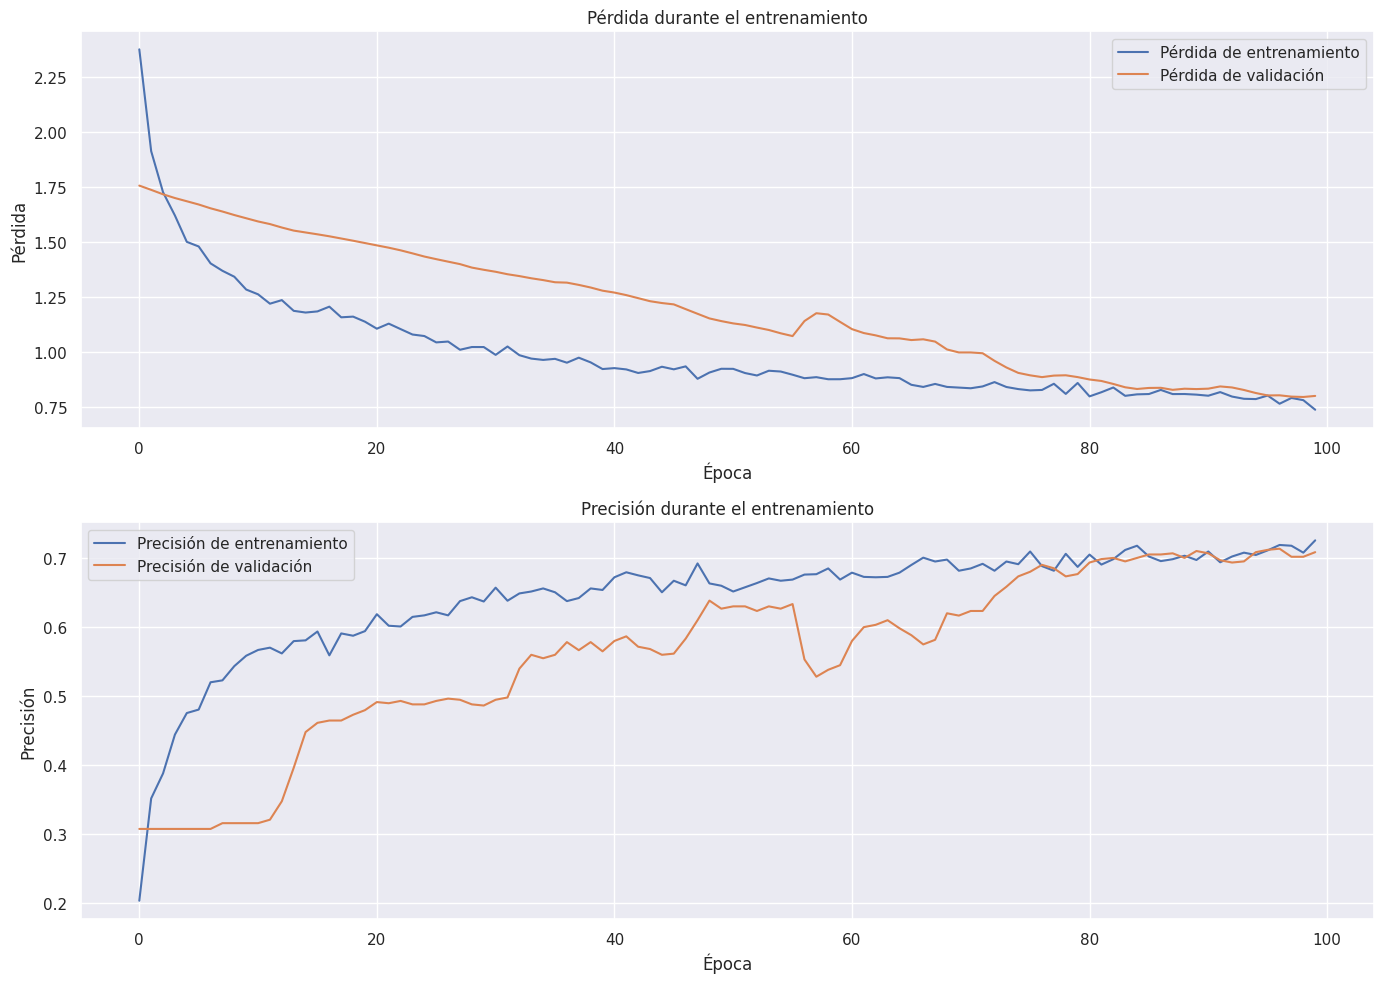

In [ ]:
plt.figure(figsize=(14,10))

# Graficar la pérdida
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la precisión
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

Los resultados del modelo muestran que tiene una pérdida de 0,7359, una precisión de 0,7249 en entrenamiento y una pérdida de validación de 0,7989 con precision de 0.7078

Estos resultados se pueden deber a que la cantidad de los datos son un poco dispersos dependiendo de la clase, por lo que un dataset con datos mas uniformes podria dar una mejor adaptacion, sin embargo probaremos el modelo si es capaz de realizar predicciones con nuevos audios

procedemos a guardar el modelo en un archivo .h5

In [ ]:
model.save('modelo_terminado.h5')

## **PREDICCIONES CON AUDIOS NUEVOS**

Para esta prueba se carga un audio de prueba en los archivos, al cual le daremos el mismo procesamiento que a los datos con los que entrenamos el modelo, para tener un estandar.

In [120]:
##--tenemos que simular el mismo pre procesamiento para este audio.
data= pd.DataFrame(columns=('path', 'age', 'gender', 'set'))
# se agrega el audio de un hombre de 20 años
data.loc[len(data)]=['prueba.wav',2,0,'nuevo']

def extract_features(files):
    try:
        file_name = os.path.join('audio de prueba/' + str(files.path))
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

        if len(X) < 50:
            return None

        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40, n_fft=2048).T, axis=0)
        stft = np.abs(librosa.stft(y=X, n_fft=2048))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate, n_fft=2048).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate, n_fft=2048).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)

        label = files.gender
        label2 = files.age

        progress_bar.update() # Incrementa la barra de progreso

        return {'mfccs': mfccs, 'chroma': chroma, 'mel': mel, 'contrast': contrast, 'tonnetz': tonnetz, 'label': label, 'label2': label2}
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

nuevo = data.apply(extract_features, axis=1)

features_new = []

for feature in nuevo:

    if feature is not None:  # Asegúrate de que no es None
        features_new.append(np.concatenate((feature['mfccs'], feature['chroma'],
                                          feature['mel'], feature['contrast'],
                                          feature['tonnetz']), axis=0))


Xnuevo = np.array(features_new)

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_Xnuevo=preprocessing.normalize(Xnuevo,norm='l2')

###--obtener la prediccion con la data el audio nuevo grabado
y_proba = model.predict(X_Xnuevo)
preds = np.argmax(y_proba, axis=1)

# # Transformamos nuestras predicciones a los ID..

preds = lb.inverse_transform(preds)

preds

1/1 [==============================] - 0s 40ms/step


array([2])

Como podemos observar el los valores de la prediccion es 2, lo que sugiere que predijo correctamente el la edad de la persona que grabo el audio

## CONCLUSIONES
Los resultados del modelo muestran que tiene un rendimiento razonable, pero podría mejorarse. Para mejorar el rendimiento del modelo, se podrían realizar las siguientes acciones:

* Reducir la cantidad de datos de entrenamiento. Esto podría ayudar a evitar el sobreajuste.
Utilizar un conjunto de datos de validación más grande. Esto podría ayudar a evaluar el rendimiento del modelo en datos nuevos.
* Tener un dataset mas equilibrado ayudaria a un mejor desempeño del modelo, logrando precisiones superiores a la hora de predecir los datos.
* En general, los resultados del modelo son prometedores. Con algunas mejoras, el modelo podría ser capaz de alcanzar un rendimiento superior.